
# PyTorch Lightning CIFAR10 ~94% Baseline Tutorial

* **Author:** PL team
* **License:** CC BY-SA
* **Generated:** 2022-04-28T08:05:29.967173

Train a Resnet to 94% accuracy on Cifar10!


---
Open in [Open In Colab{height="20px" width="117px"}](https://colab.research.google.com/github/PytorchLightning/lightning-tutorials/blob/publication/.notebooks/lightning_examples/cifar10-baseline.ipynb)

Give us a ⭐ [on Github](https://www.github.com/PytorchLightning/pytorch-lightning/)
| Check out [the documentation](https://pytorch-lightning.readthedocs.io/en/stable/)
| Join us [on Slack](https://www.pytorchlightning.ai/community)

## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "pandas" "torch>=1.6, <1.9" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "lightning-bolts"

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
# Run this if you intend to use TPUs
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [3]:
import os

import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

Global seed set to 7


### CIFAR10 Data Module

Import the existing data module from `bolts` and modify the train and test transforms.

In [4]:

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:60: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:64: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:68: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


### Resnet
Modify the pre-existing Resnet architecture from TorchVision. The pre-existing architecture is based on ImageNet
images (224x224) as input. So we need to modify it for CIFAR10 images (32x32).

In [5]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

### Lightning Module
Check out the [`configure_optimizers`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#configure-optimizers)
method to use custom Learning Rate schedulers. The OneCycleLR with SGD will get you to around 92-93% accuracy
in 20-30 epochs and 93-94% accuracy in 40-50 epochs. Feel free to experiment with different
LR schedules from https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [6]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [7]:
model = LitResnet(lr=0.05)

trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /__w/1/s/.datasets/cifar-10-python.tar.gz to /__w/1/s/.datasets


Files already downloaded and verified


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Files already downloaded and verified


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9193999767303467     │
│         test_loss         │    0.28191840648651123    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.28191840648651123, 'test_acc': 0.9193999767303467}]

,lr-SGD,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.004229,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.847524,NaN,NaN,NaN,NaN
NaN,0.004934,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.724640,NaN,NaN,NaN,NaN
NaN,0.006107,NaN,NaN,NaN,NaN,NaN


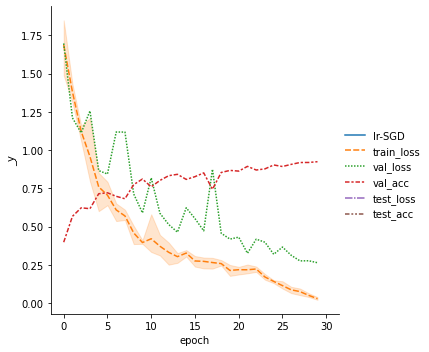

In [8]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

### Bonus: Use [Stochastic Weight Averaging](https://arxiv.org/abs/1803.05407) to get a boost on performance

Use SWA from torch.optim to get a quick performance boost. Also shows a couple of cool features from Lightning:
- Use `training_epoch_end` to run code after the end of every epoch
- Use a pretrained model directly with this wrapper for SWA

In [9]:
class SWAResnet(LitResnet):
    def __init__(self, trained_model, lr=0.01):
        super().__init__()

        self.save_hyperparameters("lr")
        self.model = trained_model
        self.swa_model = AveragedModel(self.model)

    def forward(self, x):
        out = self.swa_model(x)
        return F.log_softmax(out, dim=1)

    def training_epoch_end(self, training_step_outputs):
        self.swa_model.update_parameters(self.model)

    def validation_step(self, batch, batch_idx, stage=None):
        x, y = batch
        logits = F.log_softmax(self.model(x), dim=1)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.hparams.lr, momentum=0.9, weight_decay=5e-4)
        return optimizer

    def on_train_end(self):
        update_bn(self.trainer.datamodule.train_dataloader(), self.swa_model, device=self.device)

In [10]:
swa_model = SWAResnet(model.model, lr=0.01)
swa_model.datamodule = cifar10_dm

swa_trainer = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"),
)

swa_trainer.fit(swa_model, cifar10_dm)
swa_trainer.test(swa_model, datamodule=cifar10_dm)

/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'trained_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['trained_model'])`.
  rank_zero_warn(


GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Files already downloaded and verified


Files already downloaded and verified


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:88: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:107: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name      | Type          | Params
--------------------------------------------
0 | model     | ResNet        | 11.2 M
1 | swa_model | AveragedModel | 11.2 M
--------------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
89.392    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Files already downloaded and verified


Files already downloaded and verified


/home/AzDevOps_azpcontainer/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:126: LightningDeprecationWarning: DataModule property `test_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9204999804496765     │
│         test_loss         │    0.25821828842163086    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.25821828842163086, 'test_acc': 0.9204999804496765}]

,lr-SGD,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.004229,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.847524,NaN,NaN,NaN,NaN
NaN,0.004934,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.724640,NaN,NaN,NaN,NaN
NaN,0.006107,NaN,NaN,NaN,NaN,NaN


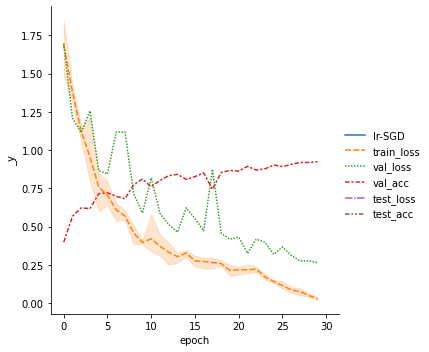

In [11]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

## Congratulations - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the Lightning
movement, you can do so in the following ways!

### Star [Lightning](https://github.com/PyTorchLightning/pytorch-lightning) on GitHub
The easiest way to help our community is just by starring the GitHub repos! This helps raise awareness of the cool
tools we're building.

### Join our [Slack](https://www.pytorchlightning.ai/community)!
The best way to keep up to date on the latest advancements is to join our community! Make sure to introduce yourself
and share your interests in `#general` channel


### Contributions !
The best way to contribute to our community is to become a code contributor! At any time you can go to
[Lightning](https://github.com/PyTorchLightning/pytorch-lightning) or [Bolt](https://github.com/PyTorchLightning/lightning-bolts)
GitHub Issues page and filter for "good first issue".

* [Lightning good first issue](https://github.com/PyTorchLightning/pytorch-lightning/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* [Bolt good first issue](https://github.com/PyTorchLightning/lightning-bolts/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)
* You can also contribute your own notebooks with useful examples !

### Great thanks from the entire Pytorch Lightning Team for your interest !

[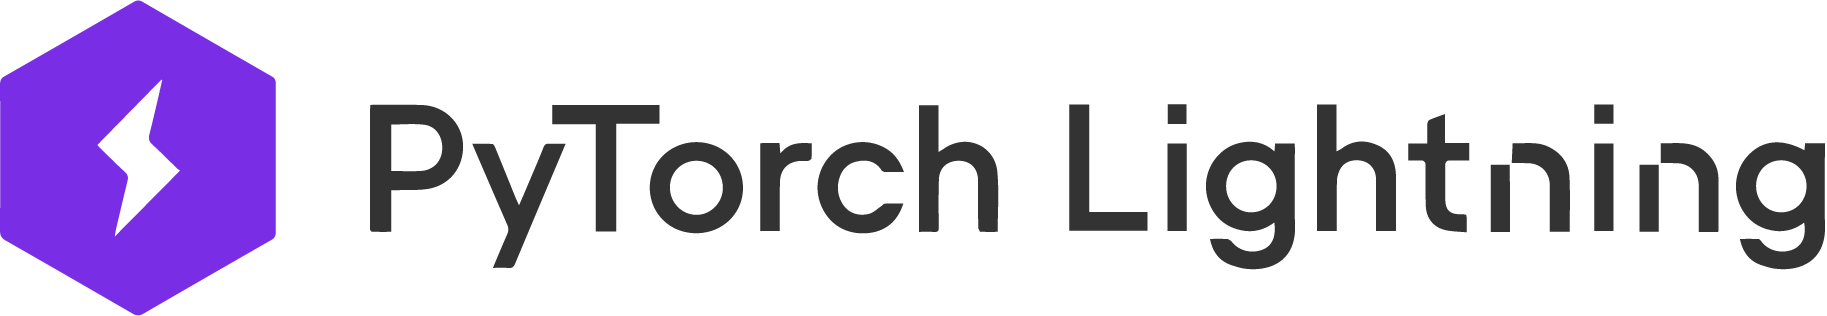{height="60px" width="240px"}](https://pytorchlightning.ai)